<div>
<table style="width: 100%">
	<tr>
		<td>
		<table style="width: 100%">
			<tr>
			<tr>
                <td><center><font size="6"><b>Calculating long-term precipitation and annual Water Balance of the Wabi Shebele Basin, South Eastern Ethiopia </b></font><center></td>
			</tr>
		</table>
		</td>
	</tr>
</table>
</div>              

# Table of contents
1. [Introduction](#introduction)
2. [Precipitation Data Analysis](#precipitation)
3. [Evapotranspiration Data Analysis](#evapotranspiration)
4. [Runoff Calculation](#runoff)  
5. [Conclusion](#conclusion)


# 1. Introduction<a name="introduction"></a>

The Wabi Shebele River Basin(WSRB) is a transboundary river basin between Ethiopia and Somalia. The Shebele River starts its journey from the south eastern Ethiopian Highlands draining through much of the Ogaden area in the Somali Region of Ethiopia. Some of the major cities in the basin include Harar, Jigjiga, Kebri Dehar and Dege Habur. The Wabi Shebele River later join the Jubba River in Somalia and finally drain to the Indian Ocean. For this study, the upper part of the basin which is mainy located in Ethiopia will be used. The basin boundary was delinated using the Global Watersheds database, which can be accessed through https://mghydro.com/watersheds/ (last accessed 18/12/2023).

The delinated basin has a large total surface area of around 190,000 km² (See Map below). The topography of the basin is highly variable, mainly due to its large surface area ranging from around 4000m above sea level (a.s.l) in the South eastern Ethiopian Highlands to around 1000m a.s.l close to the Ethio-Somalia border. The elevation map of the area is drawn from the NASA NASADEM Digital Elevation 30m https://developers.google.com/earth-engine/datasets/catalog/NASA_NASADEM_HGT_001. The Landcover map of the area is also a presented below. The map shows similar variability as the elevation differences in the area, where the cropland is a major landcover type in the highlands. The lowland areas are covered mainly by shrublands and grasslands, which are grazing araes for cattles of the pastoralist somali people. The source of the landcover map is the ESA ESA WorldCover 10m v100 for the year 2020, which can be accessed https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100

The Somali pastoralists are the main inhabitants of the lowland areas in the basin. The people require enough water to water their cattles. However, the region is know for its recurrent drought occurence. Precipitation is mostly the main source of water in the region. The pastoralist move from place to place with their cattles in search of water. Hence, the main objective of this project is to analyze the spatio-temporal variability of precipitation in the region and to determine the monthly water balance of the basin using an "average" rainfall year. To do this, precipitation data of 21 years (2001-2021) will be utilized.

To locate the study area (WSRB), the GEE map is used with google map as the basemap. The elevation is added from NASADEM, which is clipped by the study area boundary dwonloaded from https://mghydro.com/watersheds/. The map is centerd so that the basin is visible in the spatial context of the East Africa region.

In [1]:
Map = geemap.Map(add_google_map=True)
DEM = ee.Image("NASA/NASADEM_HGT/001").select("elevation")

boundary_shp = 'Wabi_Shebele/Wabi_shebele.shp'
boundary = geemap.shp_to_ee(boundary_shp)
Wabe_elev = DEM.clip(boundary)
vis_params = {
    'min': 500,
    'max': 4000,
    'palette': ['#fde725', '#5ec962', '#21918c', '#3b528b', '#440154'],
}

Map.addLayer(Wabe_elev, vis_params, 'Elevation')
Map.add_colorbar(vis_params, label="Elevation (m)", layer_name="NASA/NASADEM_HGT/001")
Map.center = [8.2, 38.9]
Map.zoom = 6
Map

NameError: name 'geemap' is not defined

The Landcover map of the WSRB is included to indicate the major landcover classes from the ESA 2020 Worldcover data. The Map centering is moved further to show the legend.

In [3]:
Map = geemap.Map(add_google_map=True)
LULC = ee.ImageCollection("ESA/WorldCover/v100").select("Map").first()

Wabe_LULC = LULC.clip(boundary)

Map.addLayer(Wabe_LULC, {}, 'Land Cover 2020')  
Map.add_legend(legend_title="Land Cover Classification", builtin_legend="ESA_WorldCover")
Map.center = [8.2, 41]
Map.zoom = 6
Map

Map(center=[8.2, 41], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

# 2. Precipitation Data Analysis <a name="precipitation"></a>
The precipitation data used for this study is the CHIRPS Monthly Precipitation data which was accessed from https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalPentadP05.html (last accessed 18/12/2023). The CHIRPS data has a 0.05° spatial resoultion, with data strating from 1981 to near real time. For this project, 21 years data (2001-2021) is downloaded. More about the CHIRPS dataset can be found here: https://www.chc.ucsb.edu/data/chirps


In this project, the <code>wget</code> python library is used to automatically download the data by stating the temporal range and a rectangular bounding box. The next 4 cell of code download the data to a folder inside the working directory. The data fromat used is NetCDF data.

In [4]:
start_date = datetime.datetime(2001,1,1)
end_date = datetime.datetime(2021,12,31)

bounding_box = [4.4, 9.6, 38.5, 45.5] #bounding_box = [latmin, latmax, lonmin, lonmax]

In [6]:
year_st = start_date.year
m_st = start_date.month
d_st = start_date.day
year_end = end_date.year
m_end = end_date.month
d_end = end_date.day

lat_1 = bounding_box[0]
lat_2 = bounding_box[1]
lon_1 = bounding_box[2]
lon_2 = bounding_box[3]

In [25]:
path_to_nc = f'https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalMonthlyP05.nc?precip%5B({year_st}-{m_st:02d}-{d_st:02d}T00:00:00Z):1:({year_end}-{m_end:02d}-{d_end:02d}T00:00:00Z)%5D%5B({lat_1}):1:({lat_2})%5D%5B({lon_1}):1:({lon_2})%5D'

In [ ]:
folder_path = "Wabi_Shebele"
wget.download(path_to_nc, out = folder_path)

Running the following code to check on the coordinates and variables of the datasets shows the presence of two variables <code>(spatial_ref, precip)</code>. For simplicity in further precipitation analysis, the <code>spatial_ref</code> will be dropped from the datset. Opening the dataset also shows the addition of data from <code>January 2022</code>, eventhough the end year was 2021. Hence, this data will also be removed. The modified dataset is saved into a new folder.

In [7]:
file_path = "Wabi_Shebele/clipped_netCDF_2001_2021.nc"
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:      (time: 253, latitude: 105, longitude: 141)
Coordinates:
  * time         (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2022-01-01
  * latitude     (latitude) float32 4.425 4.475 4.525 ... 9.525 9.575 9.625
  * longitude    (longitude) float32 38.52 38.57 38.62 ... 45.43 45.47 45.52
Data variables:
    spatial_ref  int32 ...
    precip       (time, latitude, longitude) float32 ...

In [8]:

file_path = "Wabi_Shebele/clipped_netCDF_2001_2021.nc"
ds = xr.open_dataset(file_path)

ds = ds.drop_vars('spatial_ref')
# Drop the data for January 2022
ds = ds.sel(time=~((ds['time.month'] == 1) & (ds['time.year'] == 2022)))

new_file_path = "Wabi_Shebele/clipped_netCDF_2001_2021_precip.nc"
ds.to_netcdf(new_file_path)

ds.close()

Eventhough, <code>path_to_nc</code> above clearly indicates the data to be in Monthly format the dwonloaded data was in daily format. Hence, the daily data should be changed to monthly to work on monthly or seasonal precipitation variabiliy. For now, the daily data is directly converted to annual data to work on spatial variability of rainfall in the WSRB. The annual precipiation of each year is calculated as the sum of the daily data using the time dimension. 

In [5]:
daily_netcdf = xr.open_dataset("Wabi_Shebele/clipped_netCDF_2001_2021_precip.nc")
daily_netcdf

<xarray.Dataset>
Dimensions:    (time: 252, latitude: 105, longitude: 141)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2021-12-01
  * latitude   (latitude) float32 4.425 4.475 4.525 4.575 ... 9.525 9.575 9.625
  * longitude  (longitude) float32 38.52 38.57 38.62 38.68 ... 45.43 45.47 45.52
Data variables:
    precip     (time, latitude, longitude) float32 ...

In [6]:
netcdf_annual = daily_netcdf.groupby('time.year').sum(dim='time')
netcdf_annual

<xarray.Dataset>
Dimensions:    (year: 21, latitude: 105, longitude: 141)
Coordinates:
  * latitude   (latitude) float32 4.425 4.475 4.525 4.575 ... 9.525 9.575 9.625
  * longitude  (longitude) float32 38.52 38.57 38.62 38.68 ... 45.43 45.47 45.52
  * year       (year) int64 2001 2002 2003 2004 2005 ... 2018 2019 2020 2021
Data variables:
    precip     (year, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0

One of the main objective of this project is to understand the spatio-temporal variability of precipitation in the region. To do this, an interactive map of annual precipitation for the WSRB for the years 2001-2021 is created using the <code>ncplot library</code>. The library is an easy to use interactive tool for NetCDF files https://pypi.org/project/ncplot/. The result shows the presence of large spatail variability in rainfall over the region, as one expects from large basins. The highland areas in the North and North West recieve the highest annual precipitation with around 1400 mm/year. Whereas, the lowland areas in the South and South east recieve very low precipitataions, mostly less than 200mm/year. Quantifying the temporal variabilty requires further analysis, which will be discussed later.

In [ ]:
#pip install ncplot

In [7]:
from ncplot import view
view(netcdf_annual)

:DynamicMap   [year]
   :Image   [longitude,latitude]   (precip)

The next step is to determine the annual variability of precipitation in the area. To do so, the avearge annual maps should be converted (aggregated) to average areal values. The presence of <code>0</code> values in the data will make our analysis invalid. Assuming the zero values are values outside of the actual boundary, they are dsicarded from the calculation (no pixel is expected to have annual precipiation of <code>0</code> in the area). Then, the NetCDF file is averaged along the latitude and longitude direction to get the area precipitation. 

In [8]:
netcdf_annual_masked = netcdf_annual.where(netcdf_annual != 0)
spatially_annual = netcdf_annual_masked.mean(dim=['latitude', 'longitude'])
spatially_annual

The result from the following line graph shows the presence of inter-annual variability in precipitation in the region. However, the the inter-annual variability is not as pronounced as the spatial variability of precipitation. To determine the trend the <code>np.polyfit</code> from the <code>numpay</code> library. The <code>np.polyfit</code> of degree 1 will perform a linear regression over the data. The result indicates a slope of +3.58mm/year. However, to determine if this change is significant at a given confidence interval requires further statistical analysis.

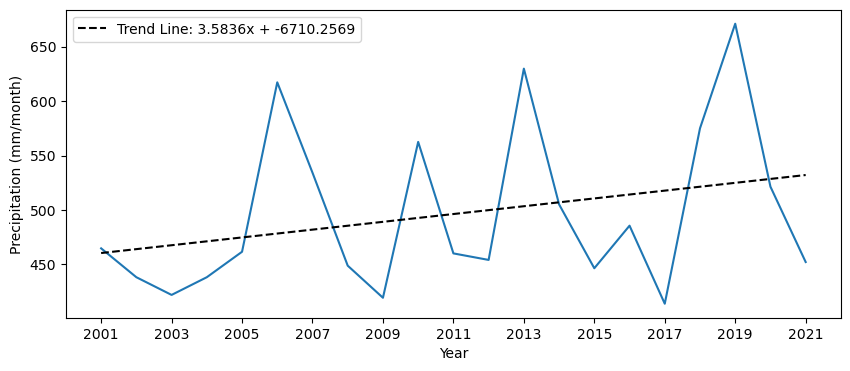

In [14]:
import numpy as np
x_values = spatially_annual['year'].values

spatially_annual['precip'].plot(figsize=(10, 4))

# Add trend line
slope, intercept = np.polyfit(x_values, spatially_annual['precip'].values, 1)
trend_line = slope * x_values + intercept
plt.plot(x_values, trend_line, color='black', linestyle='--', label=f'Trend Line: {slope:.4f}x + {intercept:.4f}')

plt.xticks(x_values[::2])

plt.xlabel('Year')
plt.ylabel('Precipitation (mm/month)')
plt.legend()

plt.show()

The Mann-Kendall test is one of the most commonly used test in hydrology to detect the presence of siginificant tren on a given confidence interval. In this project the <code>pymannkendall</code> library, which can be found https://pypi.org/project/pymannkendall/ is used to determine the presence of significant trend for the data over the given time. The default <code>alpha</code> (significant level) of 0.05 is used. The following image explains the input values and the results of the test. The result from the Mann-Kendall trend test indicates that there is no significant trend on annual precipitation for the WSRB between the years 2001-2021.

<td><center><img src='images\pymannkendall.png'></img></td>

In [ ]:
#pip install pymannkendall

In [15]:
import pymannkendall as mk

data = spatially_annual['precip']

result = mk.original_test(data)
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.29056075537876946, z=1.0568922729378545, Tau=0.17142857142857143, s=36.0, var_s=1096.6666666666667, slope=2.679729461669922, intercept=434.82312774658203)


The above graph shows the inter-annual variability of precipitation in the area. Another important aspect is also the availability of water resources in different months (seasons). The figure below shows the intra-annual variability of precipitation. The monthly data is resampled from the daily data by uisng the sum operation. To remove the values outside of the actual boundary, the condition check is conducted which is similar to the above procedure. (The sum of average monthly values of the "average" year is checked with the annual sum and were found similar). The resulting graph shows the presence of large difference between months in precipitation values ranging from close to 0 to around 200mm/year. 

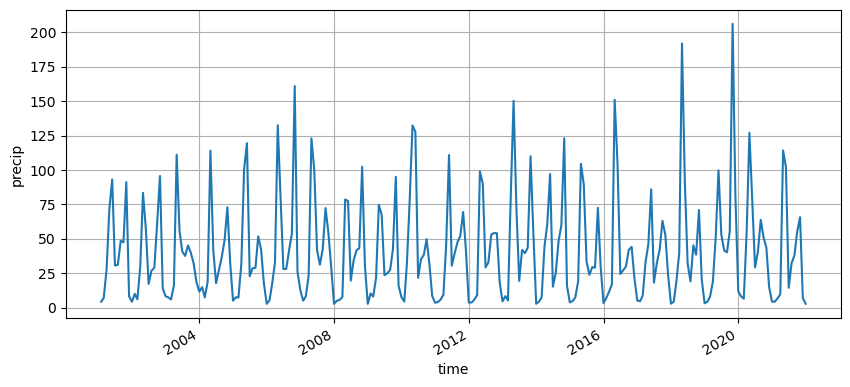

In [18]:
monthly_netcdf = daily_netcdf.resample(time='M').sum()
monthly_netcdf_masked = monthly_netcdf.where(monthly_netcdf != 0)
spatially_monthly = monthly_netcdf_masked.mean(dim=['latitude', 'longitude'])
spatially_monthly['precip'].plot(figsize=(10, 4))
plt.grid()

# Determining the "average year" of Precipitation Data
To calculate the water balance of the WSRB, a hydrologic year, where the precipitation value is close to the average is selected. This is mainly due to data availability in Evapotranspiration and computation power. The analysis will be made first by determining the mean of annual precipitation in the area and using that year as a the period which will represent the "normal" hydrologic conditions of the area. 
The result shwos that the mean value of annual precipitation for WSRB is 496.3 mm/year. The next step is to determine the year having the closest value to this mean, which is found to be 2014. Hence, the precipitation data of 2014 will be used to calculate the seasonal and annual water balance of the WSRB.

In [19]:
mean_over_time = spatially_annual.mean(dim='year')
mean_over_time

<xarray.Dataset>
Dimensions:  ()
Data variables:
    precip   float32 496.3

To analyze the spatial variation of water balance in the area, the <code>.sel</code> tool, is used together by summing along the time dimension. The resulting dataset is the exported to a NetCDF file. 

In [21]:
netcdf_2014d = daily_netcdf.sel(time = '2014')
netcdf_2014 = netcdf_2014d.groupby('time.year').sum(dim = 'time')
netcdf_2014.to_netcdf("CHIRPS_NetCDF/2014_prec.nc")

The Evapotranspiration (ET) data downloaded for the area(shown later in this notebook) is in .tif file. Hence, <code>gdal</code> is used to change the data type from NetCDF to .tif.

In [22]:
!gdal_translate -of GTiff -ot Float32 -sds "CHIRPS_NetCDF/2014_prec.nc" "CHIRPS_NetCDF/2014_prec.tif"

Input file size is 141, 105
0...10...20...30...40...50...60...70...80...90...100 - done.


The final steps in the precipitation data analysis involves exporting the data of monthly precipitation (2014) to .CSV file format for further analysis in <code>pandas</code> library.

In [23]:
prec_2014 = spatially_monthly.sel(time='2014')
prec_2014.to_dataframe().to_csv('prec_2014.csv')

# 3. Evapotranspiration Data Analysis <a name="evapotranspiration"></a>

One of the purposes of this notebook is to detrmine seasonal and spatial water resource availability in the WSRB. To achieve this, a one-year(2014) average data of precipitation and Evapotranspiration are used. The Evapotranspiration data is downloaded from the FAO WaPOR database (https://wapor.apps.fao.org/home/WAPOR_2/1) WaPOR_2, as the WaPOR_3 data cotains starting only from 2018. 

As a result, 12 tiff.files of Monthly Actual Evapotransiration and Interception for the year 2014 are downloaded for the specifc study area (WSRB). 


<td><center><img src='images\FAO_WaPOR.png'></img></td>

According to the catalog https://wapor.apps.fao.org/catalog/WaPOR_2/1/L1_AETI_MThe, the dataset which is downloaded from the portal requires correction by multiplication of 0.1. Hence, the following loop is constructed to iterate and multiply all the monthly tiff files in the folder. The corrected files are then exported to another folder.  

In [30]:
import rasterio
import numpy as np

for i in range(1, 13):
    file_number = f"{i:02d}"
    tiff_file = f"AET/L1_AETI_14{file_number}M_clipped.tif"
    
    corrected_tiff = np.multiply(rasterio.open(tiff_file).read(1, masked=True), 0.1)
    
    output_file = f"AET/AET_corrected/L1_AETI_14{file_number}M_corrected.tif"
    with rasterio.open(output_file, 'w', **rasterio.open(tiff_file).profile) as dst:
        dst.write(corrected_tiff, 1)

Similarily, another loop is constructed to iterate through the corrected .tif files and add them into a new dataarray initalized at the beginning. This will result in the annual ET of 2014 for the study area. Before summing the nodata values are excluded. This annual .tif file is then exported to a new data file through <code>rioxarray</code>. 


In [ ]:
import rioxarray as rio

et_sum = None

for i in range(1, 13):
    file_number = f"{i:02d}"
    et_file = f"AET/AET_corrected/L1_AETI_14{file_number}M_corrected.tif"
    et_data = rio.open_rasterio(et_file)
    et_data = et_data.where(et_data != et_data.rio.nodata)

    if et_sum is None:
        et_sum = et_data
    else:
        et_sum += et_data

et_sum.rio.to_raster("AET/AET_corrected/et_sum.tif")

However, the two datasets (annual precipitation and annual evapotranspiration) have different grid size and extent. Hence, the ET data is resampled to the size of the CHIRIPS precipitation data. The extent has also been matched using <code>gdalwarp</code>. The two datasets can now be utilized for raster calculations. 

In [ ]:
xmin = 38.4999938964843764 
ymin = 4.3999992517324582
xmax = 45.5499938964843807 
ymax = 9.6499961706308213
xsize = 0.05000000000000000278
ysize = 0.04999997065617488301
!gdalwarp -te xmin ymin xmax ymax -tr xsize ysize "AET/AET_corrected/et_sum.tif" "AET/AET_corrected/2014_ET_resampled.tif" 

For further temporal ET variation analysis, the resulting monthly average value is calculated as the average of the monthly maps. The <code>pandas</code> and <code>numpay</code> libraries are used to achieve this through a loop iterating over the 12 months using an initailly created dataframe. The file is the exported to a .CSV file for further water balance analysis.

In [ ]:
import pandas as pd
# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Month', 'Average_ET'])

for i in range(1, 13):
    file_number = f"{i:02d}"
    tiff_file = f"AET/AET_corrected/L1_AETI_14{file_number}M_corrected.tif"
    
    Average_ET = np.mean(rasterio.open(tiff_file).read(1, masked=True))
    result_df = result_df._append({'Month': f"Month {i}", 'Average_ET': Average_ET}, ignore_index=True)

# Save the DataFrame to a CSV file
result_df.to_csv('AET/AET_corrected/average_ET_month.csv', index=False)

# 4. Runoff Calculation <a name="runoff"></a>
One of the components of the water balance in a given area is Runoff. Runoff can be calculated from simple water balance methods. Annual Runoff in the area is calculated using the equation: <code>RO = P - ET</code>. The rasterio and numpy libraries are used to subtract the two .tif files and compute the resulting Runoff value. An attempt has been made to exclude nodata values of P and ET from the calculation as they were found to be creating Runoff values outside of the actual boundary. 

In [28]:
import rasterio
import numpy as np

p_file = "CHIRPS_NetCDF/2014_prec.tif"
with rasterio.open(p_file) as p_2014:
    p_data = p_2014.read()

et_file = "AET/AET_corrected/2014_ET_resampled.tif"
with rasterio.open(et_file) as et_2014:
    et_data = et_2014.read()

# Exclude no-data values
p_data = np.where(p_data != p_2014.nodata, p_data, np.nan)
et_data = np.where(et_data != et_2014.nodata, et_data, np.nan)

RO_2014_data = p_data - et_data
RO_2014_data = np.where(RO_2014_data < 0, 0, RO_2014_data)

output_file = "RO_2014.tif"
with rasterio.open(et_file) as template_ds:
    profile = template_ds.profile
    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(RO_2014_data)

After calculating the annual surface runoff based on the above procedure, the resulting maps are presented below. The ET and Runoff maps show their spatail depence of precipitation availability. The annual runoff of the area is less than 200mm/year for almost all of the area, except very few places upstream in the highlands. The ET also follwos the same spatial pattern, except unusually very high ET around the basin outlet, possibly due to the landcover type being herbaceous wetland according to the landcover map above. Generally, most part of the area experiences ET less than or equal to 500mm/year. 

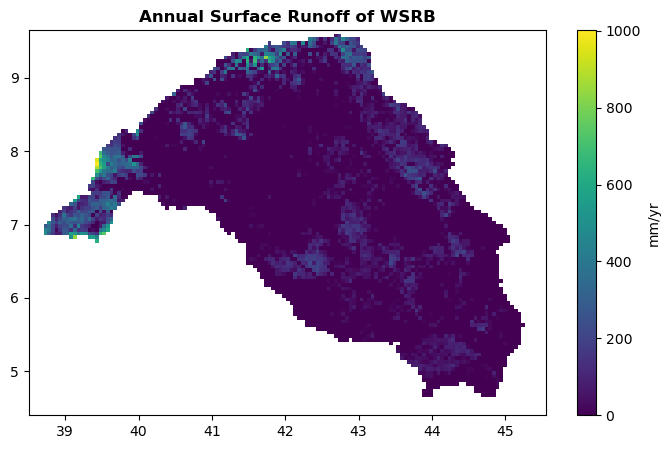

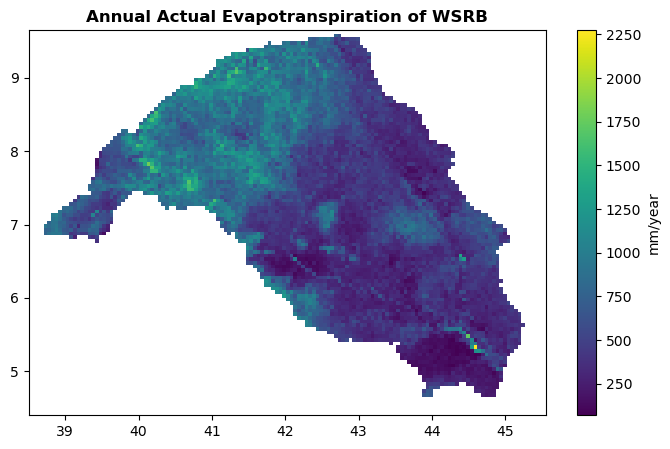

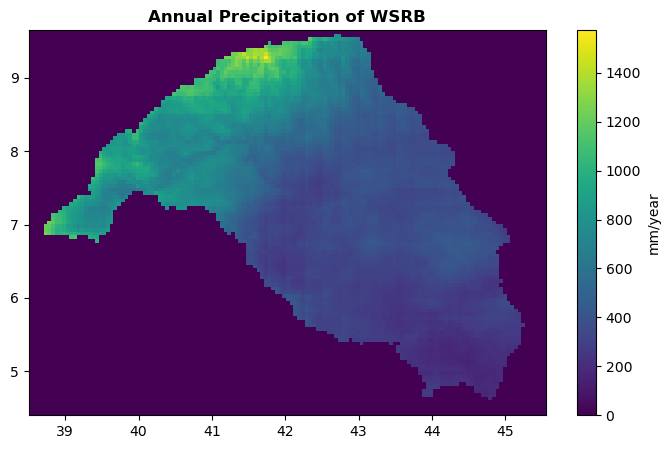

In [78]:

RO_2014 = "RO_2014.tif"
img = rasterio.open(RO_2014)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
show(img, title="Annual Surface Runoff of WSRB", ax=ax)

cbar = plt.colorbar(ax.get_children()[0], ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('mm/yr')

ET_2014 = "AET/AET_corrected/2014_ET_resampled.tif"
img = rasterio.open(ET_2014)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
show(img, title="Annual Actual Evapotranspiration of WSRB", ax=ax)

cbar = plt.colorbar(ax.get_children()[0], ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('mm/year')

P_2014 = "CHIRPS_NetCDF/2014_prec.tif"
img = rasterio.open(P_2014)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
show(img, title="Annual Precipitation of WSRB", ax=ax)

cbar = plt.colorbar(ax.get_children()[0], ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('mm/year')



The other dimension of variability in water balance analysis is temporal variability. To understand the variability of precipitation, evapotranspiration and surface runoff in seasons and months, the average monthly value of these elements is computed. The <code>pandas</code> and <code>numpy</code>libraries are used to subtract the precipitation .csv file and the ET .csv file, and store the resulting dataframe to a new .csv file for monthly runoff. 

In [81]:
df_prec = pd.read_csv("prec_2014.csv")
df_aet = pd.read_csv("AET/AET_corrected/average_ET_month.csv")

df_prec['precip'] = pd.to_numeric(df_prec['precip'])
df_aet['Average_ET'] = pd.to_numeric(df_aet['Average_ET'])

df_aet['Month'] = df_aet['Month'].str.extract('(\d+)')
df_aet['Month'] = pd.to_datetime(df_aet['Month'], format='%m').dt.strftime('%b')

df_result = pd.DataFrame({
    'Month': df_aet['Month'],
    'RO': np.where(df_prec['precip'] - df_aet['Average_ET'] >= 0, df_prec['precip'] - df_aet['Average_ET'], 0)
})

df_result.to_csv('monthly_RO.csv', index=False)


Finally, the seasonal variability of the three water balance elements (P, ET, RO) is plotted below.

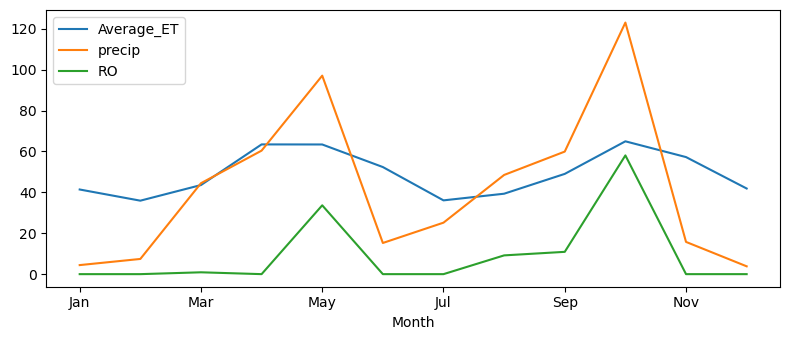

In [82]:
plt.rcParams["figure.figsize"] = [8.00, 3.50]
plt.rcParams["figure.autolayout"] = True

df_prec = pd.read_csv("prec_2014.csv")
df_aet = pd.read_csv("AET/AET_corrected/average_ET_month.csv") 
df_result = pd.read_csv("monthly_RO.csv")

ax = df_aet.plot(x='Month', y='Average_ET')
df_prec.plot(ax=ax, x='time', y='precip')
df_result.plot(ax=ax, x='Month', y='RO')

plt.show()


# 5. Conclusion <a name="conclusion"></a>

In conclusion:
The objective of this project was to determine the spatio-temporal variability of precipitation in the WSRB, to quantify the annual spatial variation of water balance components (ET & Runoff) for a given year and determine the temporal variation of these water balance compoenents for the year. 

The results indicated that the spatial variation of precipitation is highly variable owing to the large surface area and elevation variations in the basin. The Northern highlands recieve the highest annual ranfall (close to 1400mm/yr), where as the Southeastern lowlands rainfall less than 200mm/year. This brings the mean annual precipitation in the basin close to 496mm/year. 

The temporal variation in precipitation is minimum (mainly between years) and the MK trend test shows the absence of significant trend in annual rainfall for the region. However, there exists a clear variability in intra-annual timescales. 

The year 2014 was selected for further water balance analysis because its annual rainfall value(505 mm/yr.) is the closest to the mean (496 mm/yr.). The annual spatial runoff is calculated as the difference between P and ET. The ET and Surafce runoff follow similar spatial characterstics with the precipitation. 

The monthly water balance of the area shows the presence of clear temporal variability and two rainy seasons in the area. The first rainy season (Feb-May) and the second rainy season (Aug-Oct). The ET is found to be higher than the precipitation in the other months, showing that the basin is water consumer in these months. 

The results on water resource availability in space and time can help solve problems related to water shortage and drought, which are very common in the area.